In [39]:
%pylab inline

import pandas as pd

from soln.bracket import get_fixed_and_var_cost
from soln.dataset import get_augmented_train_and_test_set
from soln.dataset import get_component_info_df
from soln.dataset import inverse_log_transform_y
from soln.dataset import load_raw_components
from soln.utils import count_components

Populating the interactive namespace from numpy and matplotlib


In [2]:
%time aug_train_set, aug_test_set = get_augmented_train_and_test_set()

CPU times: user 13.3 s, sys: 148 ms, total: 13.5 s
Wall time: 13.8 s


19.0447619647 2.83680093249 0.999937805986


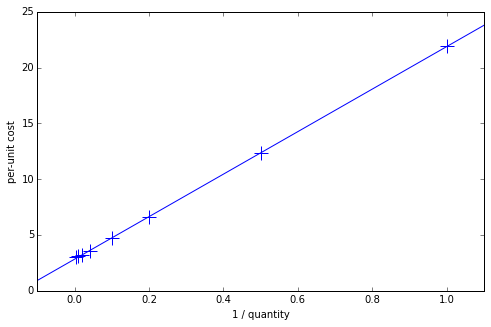

In [26]:
# From bracket_pricing.ipynb.

taid = 'TA-00002'
df = aug_train_set[aug_train_set.tube_assembly_id == taid]
quantities = df.quantity.values
costs = inverse_log_transform_y(df.log_cost.values)
fixed_cost, var_cost, r2 = get_fixed_and_var_cost(quantities, costs)
print fixed_cost, var_cost, r2

plt.figure(figsize=(8, 5))
plt.scatter(1.0 / quantities, costs, s=200, marker='+')
plt.xlabel('1 / quantity')
plt.ylabel('per-unit cost')
plt.xlim(-0.1, 1.1)
plt.ylim(0, 25)
xx = np.linspace(-0.1, 1.1, 100)
yy = fixed_cost * xx + var_cost
plt.plot(xx, yy)
plt.savefig('images/bracket.png')

In [27]:
# From bracket_pricing.ipynb.

brapa = (1, 2, 5, 10, 25, 50, 100, 250)
df = aug_train_set[aug_train_set.bracketing_pattern == brapa]
grouped = df.groupby('tube_assembly_id')
taids = []
fixed_costs = []
var_costs = []
for taid, indices in grouped.groups.iteritems():
    quantities = df.quantity[indices].values
    costs = inverse_log_transform_y(df.log_cost[indices].values)
    fixed_cost, var_cost, r2 = get_fixed_and_var_cost(quantities, costs)
    if r2 < 0.9999:
        print "{} has bad r2".format(taid)
    taids.append(taid)
    fixed_costs.append(fixed_cost)
    var_costs.append(var_cost)

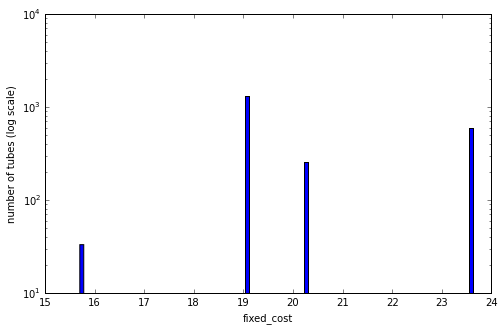

In [33]:
plt.figure(figsize=(8, 5))
plt.xlabel('fixed_cost')
plt.ylabel('number of tubes (log scale)')
plt.hist(fixed_costs, bins=100, log=True);
plt.savefig('images/fixed_costs.png')

In [40]:
# From components.ipynb.

comp_types, group_dfs, cluster_dfs = load_raw_components()
cinfo_df = get_component_info_df(comp_types, group_dfs, cluster_dfs)
train_counts = count_components(aug_train_set, cinfo_df)
train_counts.rename(columns={'count': 'train_count'}, inplace=True)
test_counts = count_components(aug_test_set, cinfo_df)
test_counts.rename(columns={'count': 'test_count'}, inplace=True)
all_counts = cinfo_df[['component_id', 'component_type_id', 'component_group_id']]
all_counts = all_counts.merge(train_counts, on='component_id')
all_counts = all_counts.merge(test_counts, on='component_id')

In [56]:
bins = [(0, 0), (1, 1), (2, 5), (5, 10), (10, 20), (20, 50), (50, 100), (100, np.inf)]
all_counts['train_bin'] = -1
for i, (cmin, cmax) in enumerate(bins):
    all_counts.train_bin.loc[(all_counts.train_count >= cmin) & (all_counts.train_count <= cmax)] = i
all_counts['test_bin'] = -1
for i, (cmin, cmax) in enumerate(bins):
    all_counts.test_bin.loc[(all_counts.test_count >= cmin) & (all_counts.test_count <= cmax)] = i

In [57]:
grouped = all_counts.groupby(['train_bin', 'test_bin'])
df = grouped.size().unstack()
str_bins = ["{}..{}".format(a, b) for (a, b) in bins]
df.index = pd.Index(str_bins, name='train_seen_count')
df.columns = pd.Index(str_bins, name='test_seen_count')
df.fillna('', inplace=True)
df

test_seen_count,0..0,1..1,2..5,5..10,10..20,20..50,50..100,100..inf
train_seen_count,,,,,,,,
0..0,346,399,81,2,,,,
1..1,407,140,83,9,,,,
2..5,111,94,112,38,2,,,
5..10,2,5,43,37,8,,,
10..20,,,,13,41,2,,
20..50,,,,,9,23,1,
50..100,,,,,,3,6,
100..inf,,,,,,,,30
